<a href="https://colab.research.google.com/github/deeplearning-itba/REINFORCE-Algorithm/blob/master/Monte_Carlo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
! pip install box2d-py
! wget https://github.com/deeplearning-itba/REINFORCE-Algorithm/raw/master/cartpole-trained.hdf5
! wget https://github.com/deeplearning-itba/REINFORCE-Algorithm/raw/master/lunar-lander-trained.hdf5

--2019-11-23 15:50:28--  https://github.com/deeplearning-itba/REINFORCE-Algorithm/raw/master/lunar-lander-trained.hdf5
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/deeplearning-itba/REINFORCE-Algorithm/master/lunar-lander-trained.hdf5 [following]
--2019-11-23 15:50:29--  https://raw.githubusercontent.com/deeplearning-itba/REINFORCE-Algorithm/master/lunar-lander-trained.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42272 (41K) [application/octet-stream]
Saving to: ‘lunar-lander-trained.hdf5’

lunar-lander-traine 100%[===================>]  41.28K  --.-KB/s    in 0.03s   

2019-11-23 15:5

In [0]:
# https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance

In [0]:
class RunningVariance:
    # Keeps a running estimate of variance

    def __init__(self):
        self.m_k = None
        self.s_k = None
        self.k = None

    def add(self, x):
        if not self.m_k:
            self.m_k = x
            self.s_k = 0
            self.k = 0
        else:
            old_mk = self.m_k
            self.k += 1
            self.m_k += (x - self.m_k) / self.k
            self.s_k += (x - old_mk) * (x - self.m_k)

    def get_variance(self, epsilon=1e-12):
        return self.s_k / (self.k - 1 + epsilon) + epsilon

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
def get_policy(env, hidden_layer_neurons = 128):
    output_shape = env.action_space.n
    input_shape = env.observation_space.shape
    model = Sequential()
    model.add(Dense(hidden_layer_neurons, input_shape=input_shape, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

In [0]:
# env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v2")
model = get_policy(env)

In [79]:
model.summary()
print(f'La dimensión de entrada de la red es {model.input.shape}')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 516       
Total params: 1,668
Trainable params: 1,668
Non-trainable params: 0
_________________________________________________________________
La dimensión de entrada de la red es (?, 8)


In [0]:
def run_episode(env, model, seed=42, explore=True):
    done = False
    if seed>0:
        env.seed(seed)
    obs = env.reset()
    rewards = []
    observations = []
    actions = []
    while not done:
        actions_dist = model.predict_proba(obs.reshape(-1, env.observation_space.shape[0]))
        if explore:
            sampled_action = np.random.choice(range(env.action_space.n), p=actions_dist[0])
        else:
            sampled_action = np.argmax(actions_dist[0])
        obs_, reward, done, _ = env.step(sampled_action)
        rewards.append(reward)
        observations.append(obs)
        actions.append(sampled_action)
        obs = obs_
    return observations, actions, rewards

![alt text](https://drive.google.com/file/d/1KDO01izeRAp6gkk5Mb12k3m3Knkzf8Ol/view)

In [0]:
def monte_carlo(env, model, seed=42, N=500, explore=True):
  returns = []
  for i in range(N):
    print(f'\rEpisodio: {i}', end='')
    observations, actions, rewards = run_episode(env, model, seed=seed, explore=explore)
    returns.append(np.sum(rewards))
  print()
  returns = np.array(returns)
  estimated_V = np.cumsum(returns)/(np.array(range(len(returns)))+1) # mu = sum(xi)/N
  variance_V_i = (returns - estimated_V)**2
  variance_V = np.cumsum(variance_V_i)/(np.array(range(len(returns)))+1e-10) # var = sum(xi-mu)^2 / N
  return estimated_V, variance_V, returns

In [82]:
%time estimated_V, variance_V, returns = monte_carlo(env, model, seed=42, N=500)

Episodio: 499CPU times: user 1min 7s, sys: 2.9 s, total: 1min 10s
Wall time: 1min


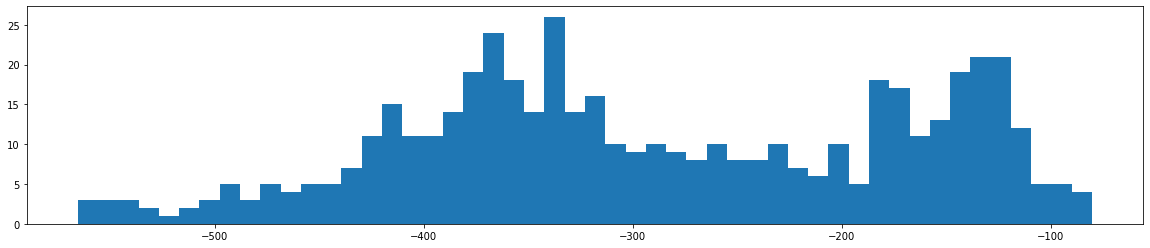

In [87]:
# Notar que los retornos como es de esperar son todos diferentes
plt.figure(figsize=(20,4))
_ = plt.hist(returns, 50)

In [0]:
running_variance = RunningVariance()
run_var = []
run_mean = []
for r in returns:
  running_variance.add(r)
  run_var.append(running_variance.get_variance())
  run_mean.append(running_variance.m_k)

In [0]:
variance_V = (returns - estimated_V)**2
variance_V = np.cumsum(variance_V)/(np.array(range(len(returns)))+1e-10)

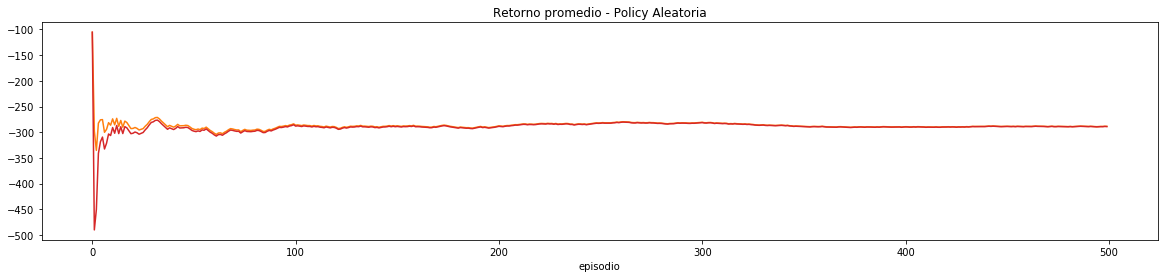

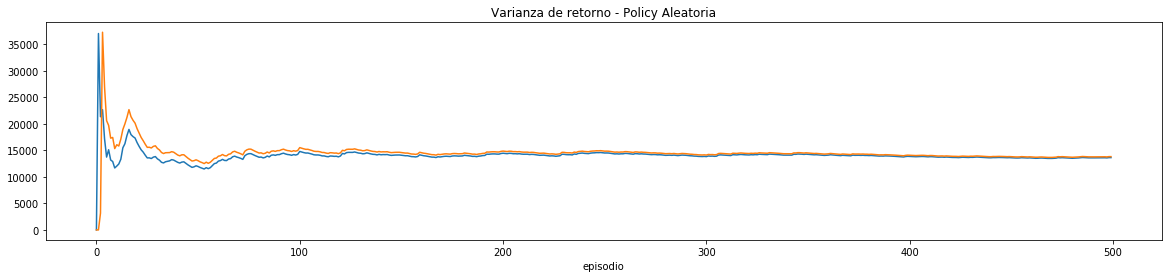

In [125]:
N=500
plt.figure(figsize=(20,4))
# plt.scatter(range(len(returns[:N])), returns[:N], c='C0')
plt.plot(estimated_V[:N], c='C1')
plt.plot(run_mean[:N], c='C3')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()
plt.figure(figsize=(20,4))
plt.plot(variance_V[:N])
plt.plot(run_var)
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()

# Modelo entrenado

In [0]:
# trained_model = load_model('/content/cartpole-trained.hdf5', compile=False)
trained_model = load_model('/content/lunar-lander-trained.hdf5', compile=False)

In [98]:
# Puede tardar mas de 2 mins
%time estimated_V_trained, variance_V_trained, returns_trained = monte_carlo(env, trained_model, seed=42, N=500)

Episodio: 499CPU times: user 3min 7s, sys: 6.49 s, total: 3min 14s
Wall time: 2min 49s


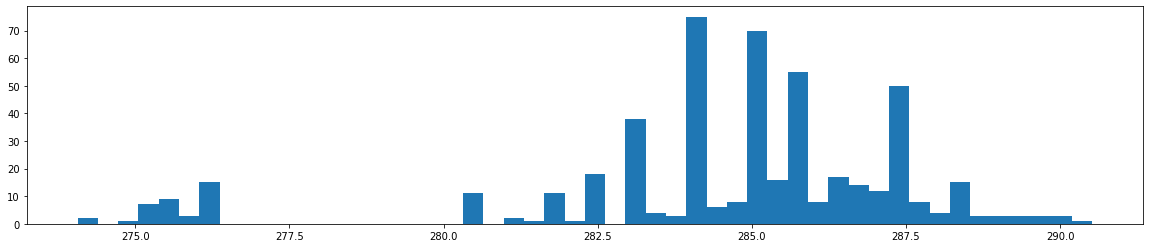

In [99]:
plt.figure(figsize=(20,4))
_ = plt.hist(returns_trained, 50)

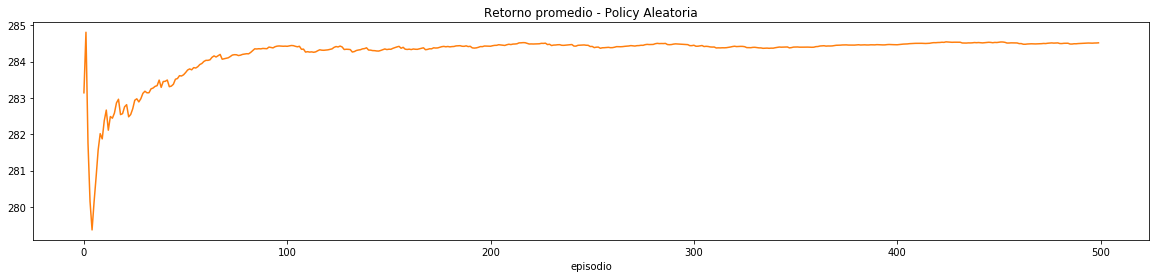

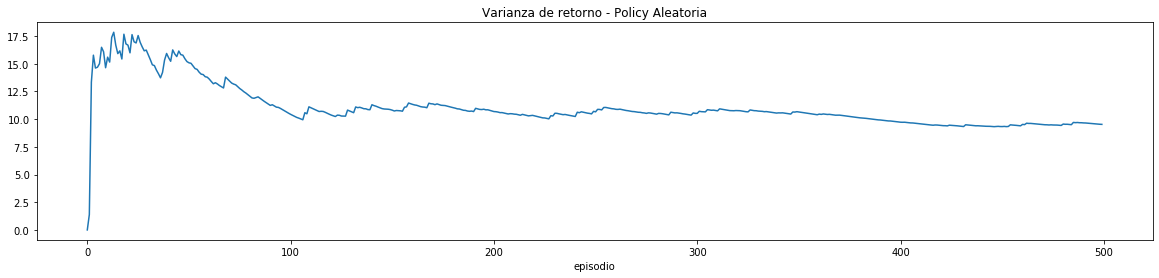

In [100]:
N=500
plt.figure(figsize=(20,4))
# plt.scatter(range(len(returns_trained[:N])), returns_trained[:N], c='C0')
plt.plot(estimated_V_trained[:N], c='C1')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()
plt.figure(figsize=(20,4))
plt.plot(variance_V_trained[:N])
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()